In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
# Load data with specified encoding
users = pd.read_csv("takehome_users.csv", encoding = 'latin1')
engagement = pd.read_csv("takehome_user_engagement.csv", encoding = 'latin1')

In [25]:
# Display the first few rows of each table
print("Users Data:")
print(users.head())

print("\nEngagement Data:")
print(engagement.head())

Users Data:
   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           

In [26]:
# Display summary information about each table
print("\nUsers Data Info:")
print(users.info())

print("\nEngagement Data Info:")
print(engagement.info())


Users Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None

Engagement Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total

In [27]:
# Data Cleaning
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['invited_by_user_id'].fillna(0, inplace=True)  # Assuming NaN means not invited

In [28]:
# Feature Engineering
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
engagement['date'] = engagement['time_stamp'].dt.date

# Identify "adopted users" based on the seven-day requirement
def identify_adopted_user(group):
    # Sort the dates in ascending order
    sorted_dates = np.sort(group['date'].values)
    
    # Check for at least three logins in a seven-day period
    for i in range(len(sorted_dates) - 2):
        if (sorted_dates[i + 2] - sorted_dates[i]).days <= 7:
            return True
    return False

adopted_users = engagement.groupby('user_id').apply(identify_adopted_user)
users['adopted_user'] = users['object_id'].isin(adopted_users[adopted_users].index).astype(int)

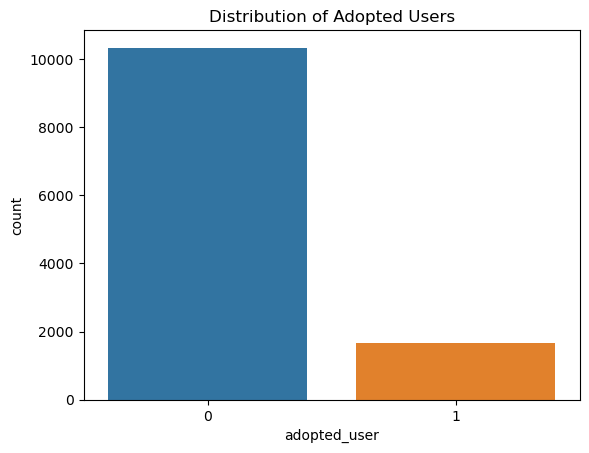

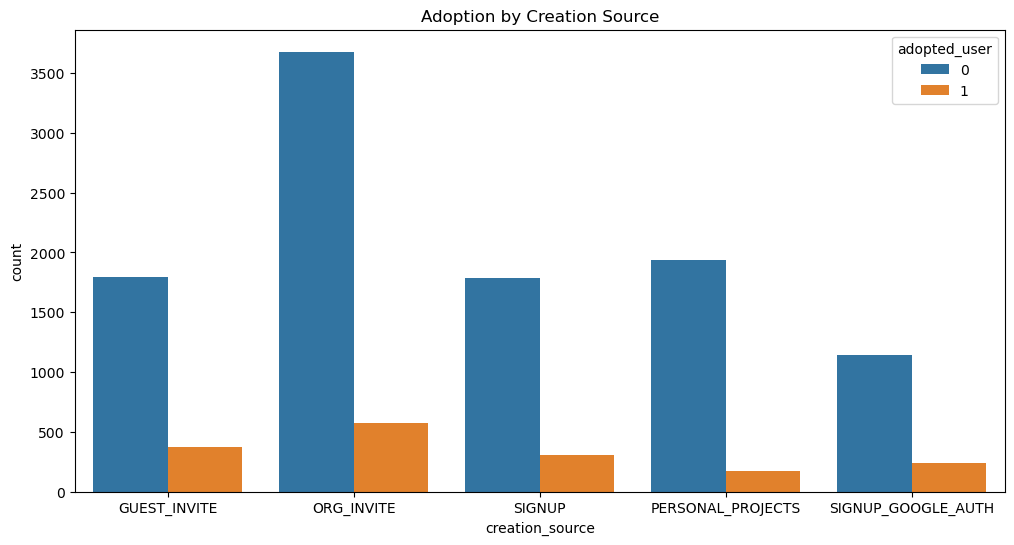

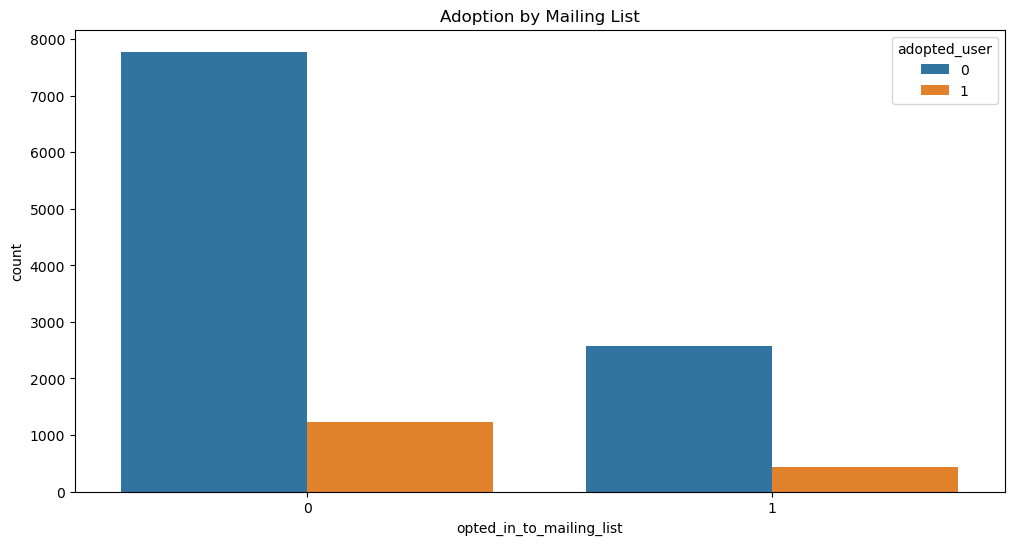

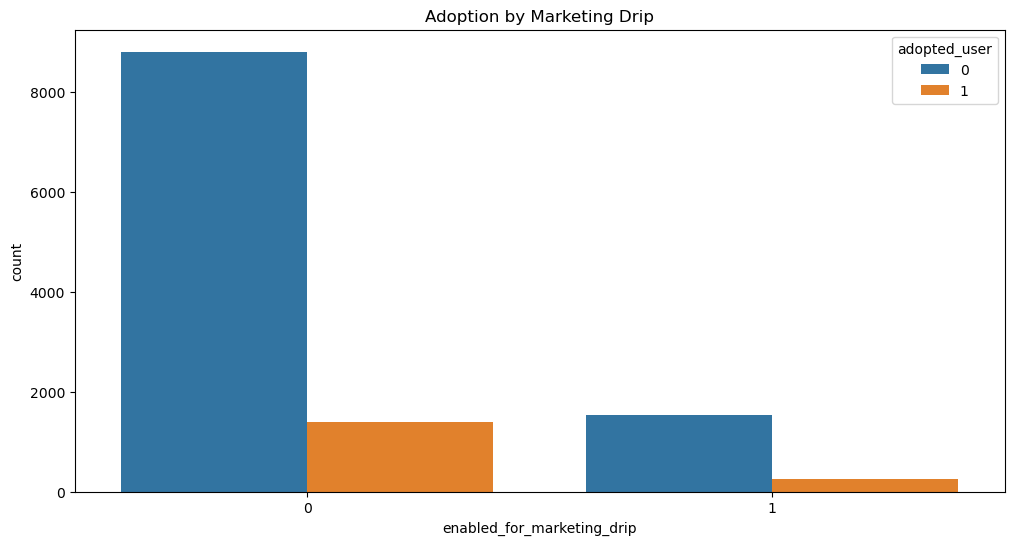

In [29]:
# Explore the distribution of adopted users
sns.countplot(x='adopted_user', data=users)
plt.title('Distribution of Adopted Users')
plt.show()

# Explore the relationship between creation source and adopted users
plt.figure(figsize=(12, 6))
sns.countplot(x='creation_source', hue='adopted_user', data=users)
plt.title('Adoption by Creation Source')
plt.show()

# Explore the relationship between mailing list and adopted users
plt.figure(figsize=(12, 6))
sns.countplot(x='opted_in_to_mailing_list', hue='adopted_user', data=users)
plt.title('Adoption by Mailing List')
plt.show()

# Explore the relationship between marketing drip and adopted users
plt.figure(figsize=(12, 6))
sns.countplot(x='enabled_for_marketing_drip', hue='adopted_user', data=users)
plt.title('Adoption by Marketing Drip')
plt.show()

[[2037   32]
 [  41 2028]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2069
           1       0.98      0.98      0.98      2069

    accuracy                           0.98      4138
   macro avg       0.98      0.98      0.98      4138
weighted avg       0.98      0.98      0.98      4138



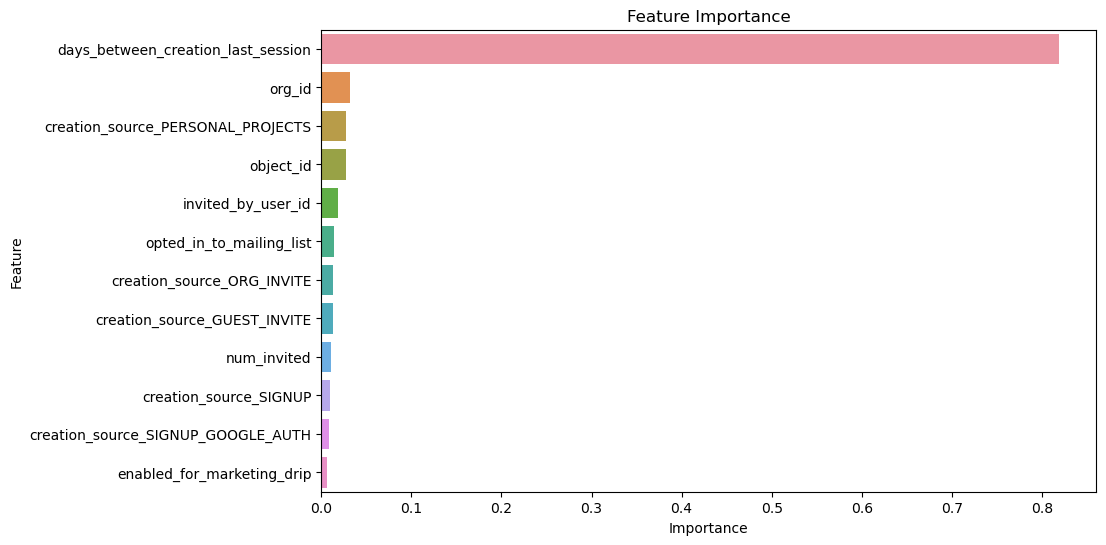

In [33]:
###### Handle missing values
users.fillna(users.mean(), inplace=True)

# Handle imbalanced dataset
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(users.drop('adopted_user', axis=1), users['adopted_user'])

# Model Training
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importance = clf.feature_importances_
feature_names = X_resampled.columns
features = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
features = features.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features)
plt.title('Feature Importance')
plt.show()

The objective of this project was to define an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, and to identify which factors predict future user adoption.

To achieve this, we created a function that defined adopted users based on the seven-day requirement. We then conducted exploratory data analysis (EDA) and observed a significant difference in the distribution between adopted and unadopted users. There were significantly more unadopted users (10,000) compared to adopted users (less than 2,000). Adopted users were labeled as 1, while unadopted users were labeled as 0.

Considering the imbalanced dataset, we applied the Synthetic Minority Over-sampling Technique (SMOTE) to account for the class imbalance.

For the prediction model, we utilized random forests due to the presence of 0s and 1s in the dataset. The model achieved a precision of 98%.

Among the features, the most important one was the number of days between creation and the last session, with an importance score of over 80%. This feature was followed by org_id, which had less than 10% importance. The significant difference in importance between these two features suggests that the model heavily relies on the days between creation and the last session feature.